In [1]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
import os
import scipy.io as sio
print(tf.config.list_physical_devices()) # Verify you have a GPU available. Not required
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


In [2]:

folder_path = "../data/WFDB/"
# Loops thorugh the .hea files and re formats them according to WFDB standards. This dataset included a .mat file type at the end and thew an error. 
# This loop modifies the .hea files by only removing the .mat text if its found on the line. 

for filename in os.listdir(folder_path):
    if filename.endswith(".hea"):
        file_path = os.path.join(folder_path, filename)
        
        # Read the contents of the .hea file
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        # Adjust and format the header lines to remove ".mat" at the end
        adjusted_lines = []
        for line in lines:
            adjusted_line = line.replace(".mat", "")
            adjusted_lines.append(adjusted_line)
        
        # Write the adjusted lines back to the .hea file
        with open(file_path, 'w') as file:
            file.writelines(adjusted_lines)

In [3]:

import os
import numpy as np
import wfdb
import tensorflow as tf
import traceback

folder_path = "../data/WFDB/"

def wfdb_mat_load(path):
    data = []
    for filename in os.listdir(path):
        if filename.endswith(".mat"):
            record_data = sio.loadmat(os.path.join(path, filename))
            if(record_data['val'].shape == (12,5000)):
                data.append(np.array(record_data['val']))
    return data


def wfdb_hea_load(path):
    hea_files = []
    for filename in os.listdir(path):
        if filename.endswith(".hea"):
            base_name, file_type = os.path.splitext(filename)
            file_path = os.path.join(path, base_name)
            header = wfdb.rdheader(path+base_name)
            hea_files.append(header)
    return hea_files

# Incorporates both loading functions so that any data excluded from X is removed from the corresponding Y.
def wfdb_loader(path):
    data = []    
    hea_files = []
    for filename in os.listdir(path):
        if filename.endswith(".mat"):
            record_data = sio.loadmat(os.path.join(path, filename)) # First handles the .mat file
            if record_data['val'].shape == (12, 5000):
                data.append(np.array(record_data['val']))
                header = wfdb.rdheader(path + filename.split(".")[0]) # Switches to .hea file
                hea_files.append(header)
    
    return (tf.cast(tf.transpose(np.array(data), perm=[0, 2, 1])
, dtype=tf.float64)/500), hea_files


sampling_rate = 500

# Load raw signal data
with tf.device('/CPU:0'):
    X_nan, Y_raw = wfdb_loader(folder_path)

In [4]:
Y_nan = []
for hea in Y_raw:
    metadata = {}
    for line in hea.comments[0:]:
        key, value = line.strip("#").split(":")
        metadata[key.strip()] = value.strip()
    Y_nan.append(metadata)

Y_nan = pd.DataFrame(Y_nan)
X_nan.shape, Y_nan.shape

(TensorShape([10292, 5000, 12]), (10292, 6))

In [5]:
with tf.device('/CPU:0'):
    Y_temp = (Y_nan[Y_nan.Age.values != 'NaN'].Age.values).astype(int)
    valid_inds = Y_temp < 89
    Y = Y_temp[valid_inds]
    X = np.asarray((X_nan[Y_nan.Age.values != 'NaN'])[valid_inds])

In [6]:
X.shape, Y.shape


((10101, 5000, 12), (10101,))

In [7]:

import numpy as np
from scipy import signal

def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

#____________________________________________________________________________________#

bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

#____________________________________________________________________________________#

# Define the filter parameters
fs = 100  # Sampling frequency (Hz)
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 40.0  # Higher cutoff frequency (Hz)
filter_order = 4  # Filter order

def bandpass(X, fs, lowcut, highcut, filter_order):
    # Apply bandpass filter to each channel
    filtered_data = np.zeros_like(X)
    for i in range(X.shape[2]):
        for j in range(X.shape[0]):
            b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
            filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

    # Print the shape of the filtered data
    return filtered_data

#____________________________________________________________________________________#

def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

#func_dict = [{'func': normalize, 'params': [None]}]

#func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

# func_dict =[{'func': normalize, 'params': [None]},
#             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
#             {'func': baseline_drift, 'params': [0,0.075]}]

In [8]:

with tf.device('/CPU:0'):
    func_dict =[{'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
                {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best
    X_final = da_apply(X, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X


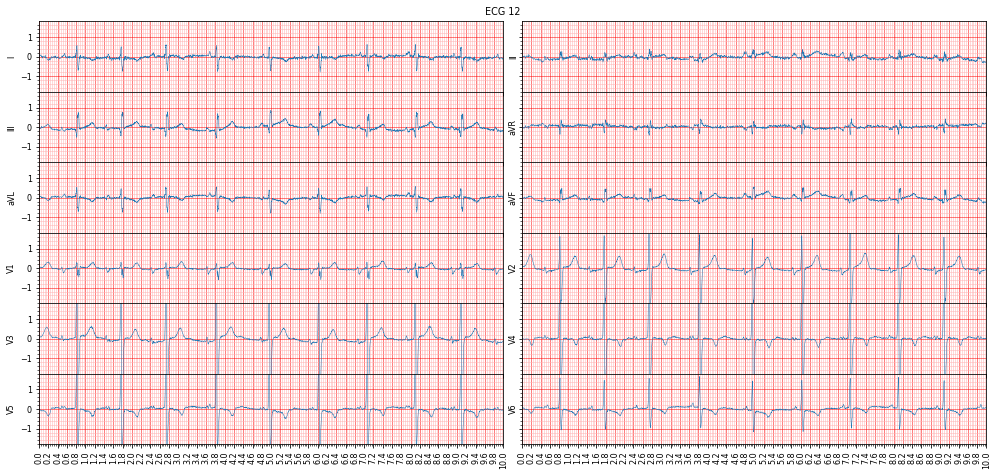

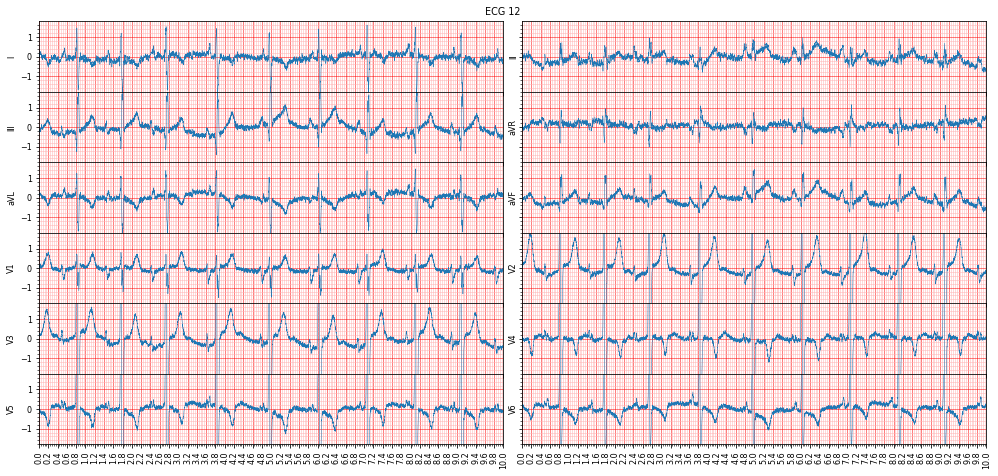

In [16]:
with tf.device('/CPU:0'):
    ecg_plot.plot_12(tf.transpose(X, perm=[0, 2, 1])[0], sample_rate=500)
    ecg_plot.plot_12(tf.transpose(X_final, perm=[0, 2, 1])[0], sample_rate=500)

In [10]:
ecg_age_model_2 = tf.keras.models.load_model("../saved_models/500hz/age_models/model_1.h5")

In [11]:
with tf.device('/CPU:0'):
    temp = ecg_age_model_2(tf.convert_to_tensor(X_final))

predicted_temp = np.asarray(tf.squeeze(temp))

In [12]:
actual_temp = Y

sorted_indices = np.argsort(actual_temp)
actual_sorted = actual_temp[sorted_indices]
predicted_sorted = predicted_temp[sorted_indices]


In [13]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(actual_sorted, predicted_sorted)

10.840023540598416

In [14]:
import seaborn as sns   # Remeber to install seaborn

def age_bar(actual, predicted):
    # Create a DataFrame from the data
    data = pd.DataFrame({'Category': np.squeeze(actual), 'Values': np.squeeze(predicted)})  # Merges the Actual and predicted data

    # Create a group boxplot using seaborn
    plt.figure(figsize=(25, 10))
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    sns.boxplot(x='Category', y='Values', data=data, width=0.6)   # Takes the unique values for X and plots them with all associated Y values. Thus a boxplot range is produced
    category_positions = range(len(data['Category'].unique()))
    plt.scatter(category_positions, np.unique(np.squeeze(actual)), color='black', label='Scatter Plot', alpha = 0.7)   # The true line represents what the predicted age should be. 
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.yticks(range(0, 110, 5)) 
    plt.title("Evaluation of the 500hz Model")
    plt.show()

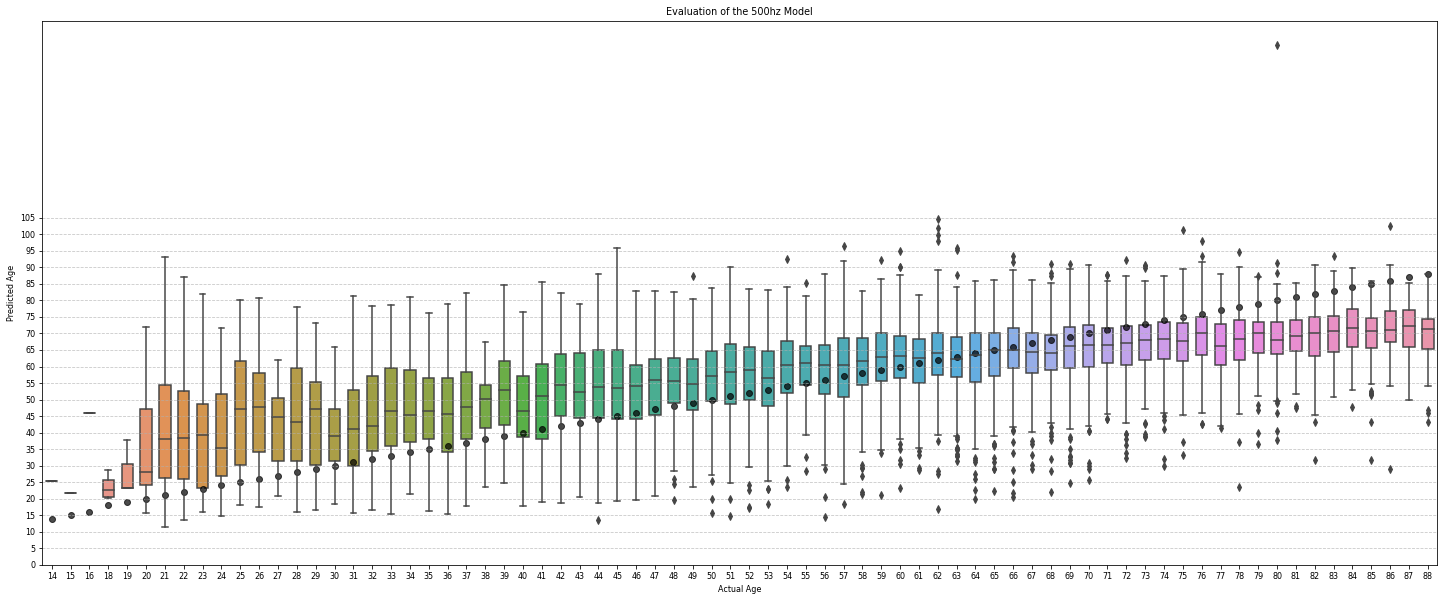

In [15]:
age_bar(actual_sorted, predicted_sorted)